Some definitions

2023-12-14 21:28:18.085917: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/nvidia
2023-12-14 21:28:18.085934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Two people looking at a large kitchen  000000000338_0.png


2023-12-14 21:28:28.255 | INFO     | lavis.models:load_model_and_preprocess:150 - Loading the preprocessors from the default config file...
2023-12-14 21:28:28.256 | INFO     | lavis.models:load_model_and_preprocess:151 - args:{'model': {'arch': 'blip_image_text_matching', 'load_finetuned': True, 'finetuned': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth', 'vit_type': 'large', 'vit_grad_ckpt': False, 'vit_ckpt_layer': 0, 'image_size': 384, 'med_config_path': 'configs/models/med_large_config.json', 'embed_dim': 256}, 'preprocess': {'vis_processor': {'eval': {'name': 'blip_image_eval', 'image_size': 384}}, 'text_processor': {'eval': {'name': 'blip_caption'}}}}
2023-12-14 21:28:28.256 | INFO     | lavis.models:load_preprocess:94 - Visual pretrained model: {'eval': {'name': 'blip_image_eval', 'image_size': 384}} | Text pretrained model: {'eval': {'name': 'blip_caption'}}
/home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELIN

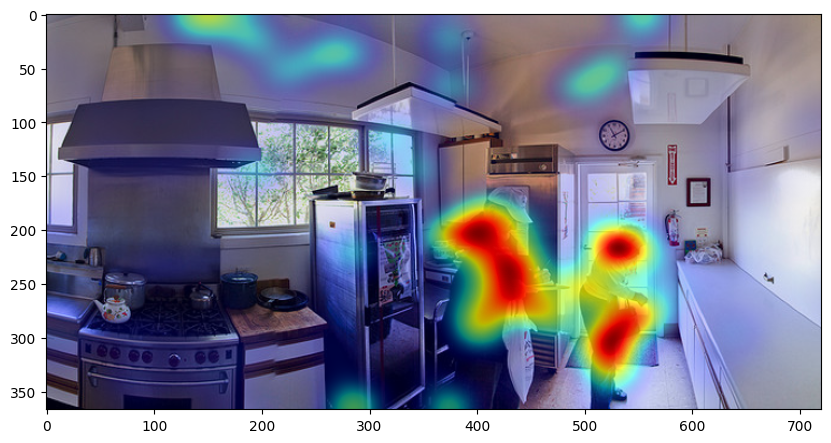

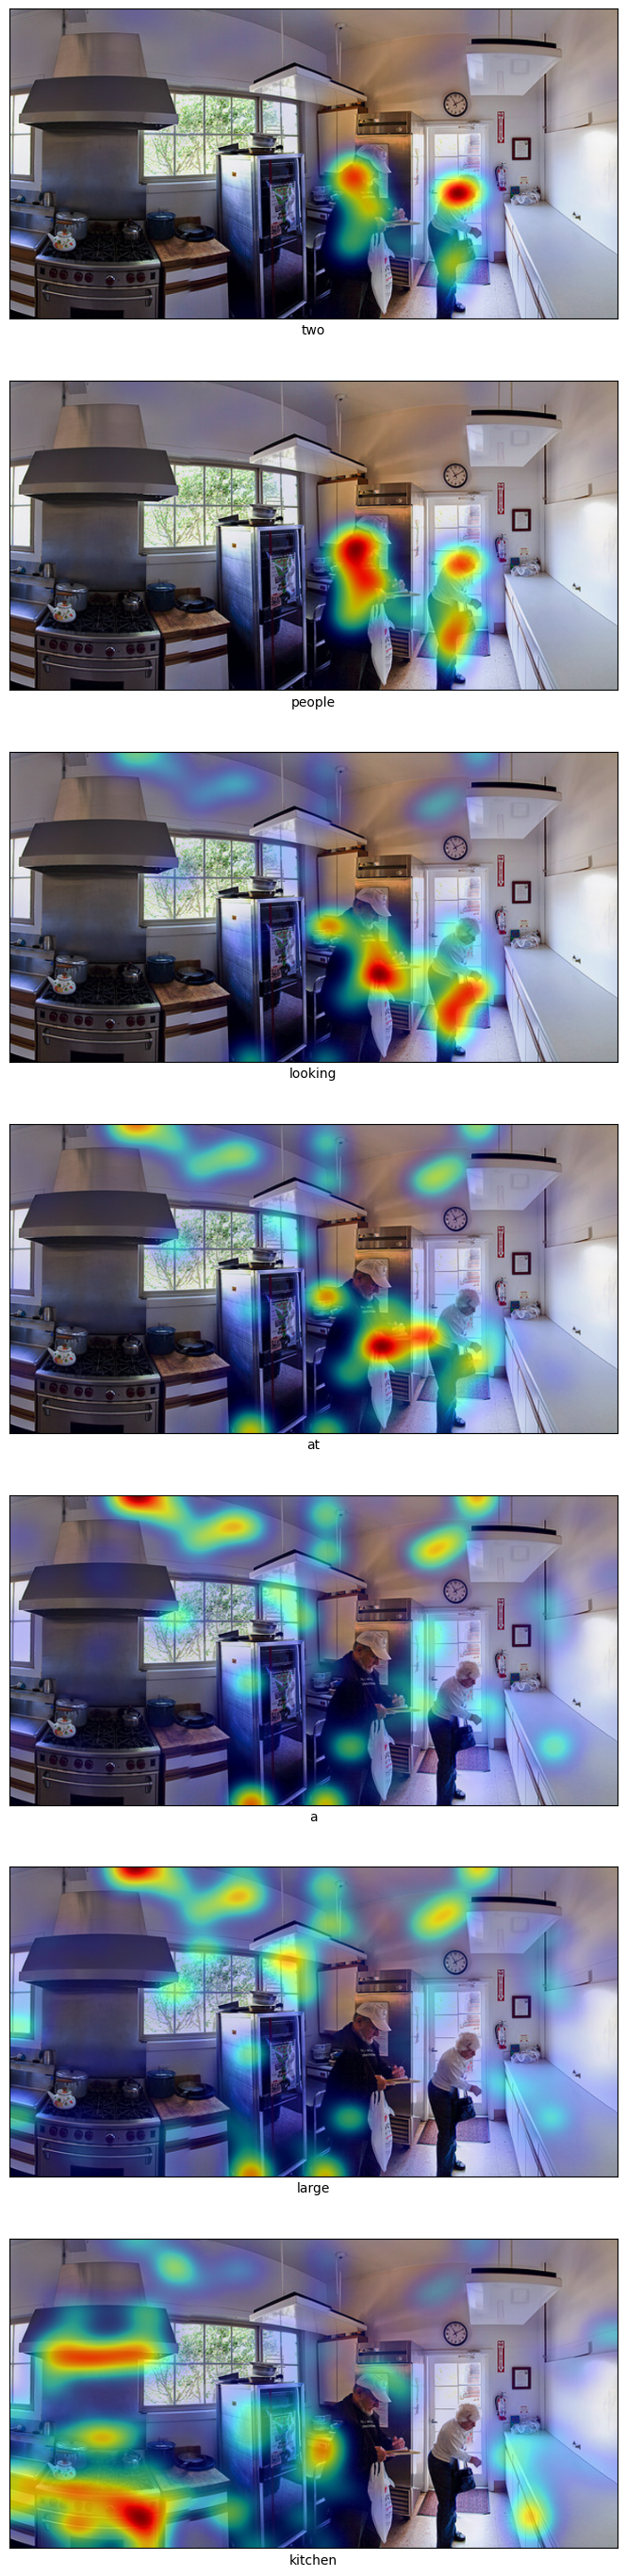

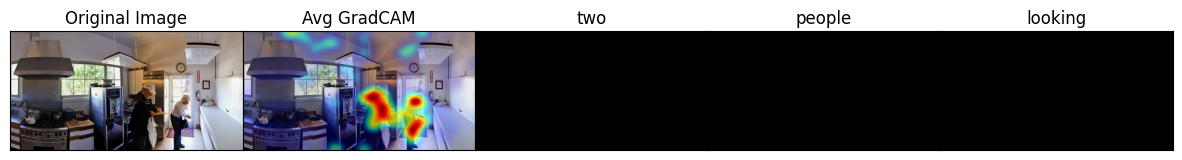

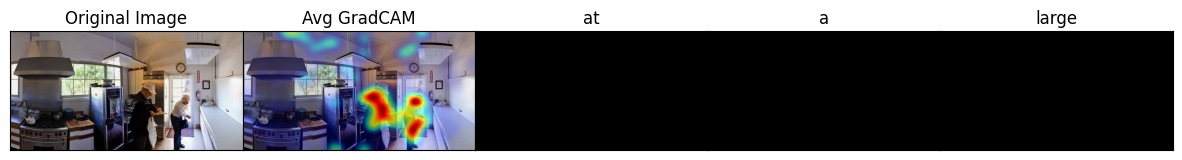

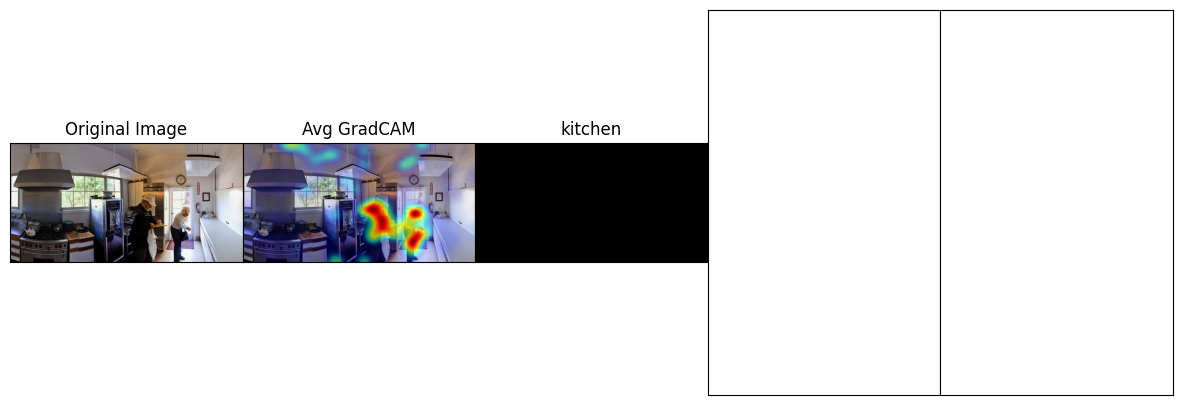

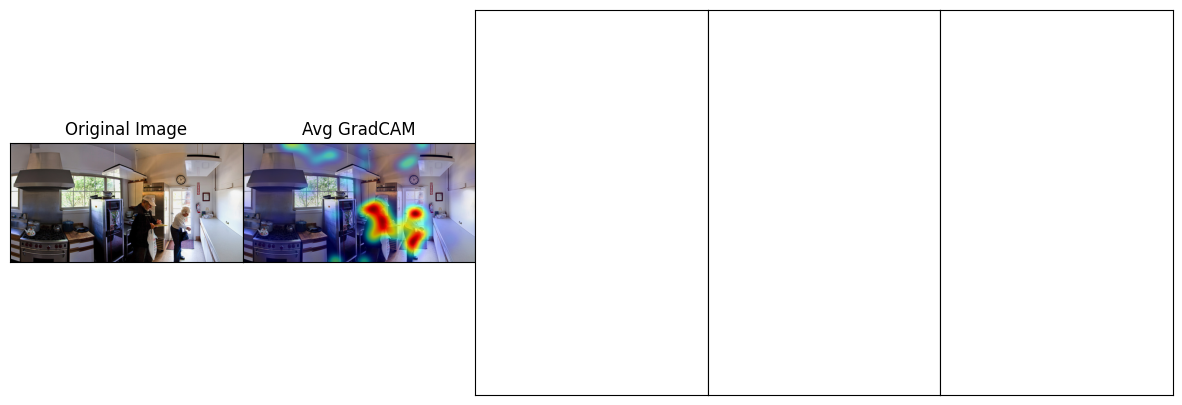

In [1]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np
from pysaliency.datasets import Stimulus, Fixations,  StimuliStimulus
import pysaliency
from pysaliency.external_datasets.sjtuvis import TextDescriptor

def handle_stimulus(stimulus):
    """
    Make sure that a stimulus is a `Stimulus`-object
    """
    if not isinstance(stimulus, Stimulus):
        stimulus = Stimulus(stimulus)
    return stimulus

import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch    
from typing import Optional, Tuple, List, Dict, Any, Union, Sequence
import pysaliency
DEVICE = 'cuda'

class DeepGazeSaliencyModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, block_num=7, dst_w=720, version = 1):
        super().__init__()
        if version == 1:
            self.model = deepgaze_pytorch.DeepGazeI(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 2:
            self.model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 3:
            self.model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = True
        self.block_num = block_num
        self.dst_w = dst_w
        
    def _saliency_map(self, stimulus, text_description:Optional[str]=None):
        image = stimulus
        # print("The input image....")
        # print(image.shape, image.dtype, np.min(image), np.max(image))
        fixation_history_x = np.array([1024//2, 300, 500, 200, 200, 700])
        fixation_history_y = np.array([768//2, 300, 100, 300, 100, 500])

        centerbias_template = np.load('../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        centerbias -= logsumexp(centerbias)

        image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
        centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

        if self.use_hist_scan_path:
            x_hist_tensor = torch.tensor([fixation_history_x[self.model.included_fixations]]).to(DEVICE)
            y_hist_tensor = torch.tensor([fixation_history_y[self.model.included_fixations]]).to(DEVICE)
            log_density_prediction = self.model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)
        else:
            log_density_prediction = self.model(image_tensor, centerbias_tensor)

        # f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        # axs[0].imshow(image)
        # axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[0].set_axis_off()
        # axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
        # axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[1].set_axis_off()
        if log_density_prediction.dim() == 2:
            pass
        elif log_density_prediction.dim() == 4:
            log_density_prediction = log_density_prediction[0, 0]
        elif log_density_prediction.dim() == 3:
            print(log_density_prediction.shape)
            assert log_density_prediction.shape[0] == 1
            log_density_prediction = log_density_prediction[0]
        assert log_density_prediction.dim() == 2, "log_density_prediction should be a 3D tensor, but is {}".format(log_density_prediction.shape)
        return log_density_prediction.detach().cpu().numpy()
    
data_location = "../../datasets/"
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
print(text_descriptor.get_description('000000020777_2.png')) 
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis("../../datasets/test/original_sjtuvis_dataset", location=data_location, text_descriptor=text_descriptor)

idx = 15
stimulus = Image.fromarray(mit_stimuli[idx].stimulus_data)
filename = os.path.basename(mit_stimuli[idx].filename)
text_description=text_descriptor.get_description(filename)
print(text_description, filename)
 
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)

dst_w = 720
raw_image = stimulus
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](text_description)
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_gradcam)

num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(norm_img, gradcam, blur=True)
    ax[i].imshow(gradcam_image)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(word)
    
    
    # Maximum number of rows and columns per row
max_rows = 10
max_cols_per_row = 5  # Adjust based on desired layout

# Determine the number of tokens to be displayed in each row
num_tokens = len(txt_tokens.input_ids[0]) - 2
tokens_per_row = min(max_cols_per_row - 2, num_tokens)  # Subtract 2 for original and avg_gradcam

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for row in range(max_rows):
    # Create a subplot for this row
    fig, axes = plt.subplots(1, tokens_per_row + 2, figsize=(15, 5))  # Adjust figsize as needed
    
    # Display the original image and avg_gradcam
    axes[0].imshow(norm_img)
    axes[0].set_title("Original Image")
    axes[1].imshow(avg_gradcam)
    axes[1].set_title("Avg GradCAM")

    for col in range(2, tokens_per_row + 2):
        try:
            gradcam, token_id = next(zip(gradcam_iter, token_id_iter))
        except StopIteration:
            break  # No more tokens to display

        word = model.tokenizer.decode([token_id])
        gradcam_image = getAttMap(norm_img, gradcam, blur=True)
        axes[col].imshow(gradcam_image)
        axes[col].set_title(word)

    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])

    plt.subplots_adjust(wspace=0, hspace=0)  # Remove gaps between subplots
    plt.show()

    if row * tokens_per_row >= num_tokens:
        break  # Stop if we have displayed all tokens